### Toxic Comment Classification with CNN_LSTM
#### Aurthur: Kamal Pangeni

Ref: https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/overview/description

In [1]:
import pandas as pd
import numpy as np
import re
import os

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

stemmer= PorterStemmer()
lemmatizer=WordNetLemmatizer()
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/kpangen1/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
path_to_maindir = '../toxic_comments/'

In [3]:
#import data
df = pd.read_csv(path_to_maindir+'train.csv')
df_test = pd.read_csv(path_to_maindir+'test.csv')

In [4]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [43]:
df_test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


### Text Preprocessing

In [44]:
def text_prepare(text):

    """
        text: a string
        return: modified initial string
    """

    text = text.lower() # lowercase text
    text = text.strip() # remove white spaces
    text = re.sub('-',' ',text) # split text on '-'
    text = re.sub(r'[^\w\s]',' ',text)# remove punctuation
    #text = re.sub(r'\w*\d\w*','', text).strip()
    text = re.sub('\n',' ',text)
    text = ' '.join([word for word in text.split() if word not in STOPWORDS]) # remove stopwords
    #text = ' '.join([stemmer.stem(word) for word in text.split()])
    #text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    
    return text

In [45]:
df['comment_text'].values[0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [46]:
text_prepare(df['comment_text'].values[0])

'explanation edits made username hardcore metallica fan reverted vandalisms closure gas voted new york dolls fac please remove template talk page since retired 89 205 38 27'

In [47]:
df['comment_text_processed'] = df['comment_text'].apply(text_prepare)
df_test['comment_text_processed'] = df_test['comment_text'].apply(text_prepare)

In [48]:
X = df['comment_text_processed']
y = df.drop(['id','comment_text','comment_text_processed'],axis=1)

In [49]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1,random_state=42)

### Text vectorization

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [51]:
vectorizer=TfidfVectorizer(ngram_range=(1,1),min_df=3, max_df=0.95,

                           strip_accents='unicode', use_idf=1,smooth_idf=1, sublinear_tf=1,max_features=None)

vectorizer.fit(df['comment_text_processed'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.95, max_features=None, min_df=3,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=1,
        stop_words=None, strip_accents='unicode', sublinear_tf=1,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=1,
        vocabulary=None)

In [52]:
print('length of vectorized vocab: ',len(vectorizer.vocabulary_))

length of vectorized vocab:  52641


### CNN+LSTM Implementation

In [53]:
from keras import regularizers
from keras.models import Model,Sequential
from keras.layers import Dense,Dropout,Activation,concatenate,Flatten,Input
from keras.layers import Embedding,LSTM,Conv1D,AveragePooling1D,MaxPooling1D,Bidirectional
from keras.optimizers import Adam,RMSprop,SGD,Adadelta
from keras.layers.normalization import BatchNormalization
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer 

In [54]:
word2idx = {word: idx for idx, word in enumerate(vectorizer.get_feature_names())}
tokenize = vectorizer.build_tokenizer()
preprocess = vectorizer.build_preprocessor()

def to_sequence(tokenizer, preprocessor, index, text):
    words = tokenizer(preprocessor(text))
    indexes = [index[word] for word in words if word in index]
    return indexes

X_train_sequences = [to_sequence(tokenize, preprocess, word2idx, x) for x in X_train]
X_val_sequences = [to_sequence(tokenize, preprocess, word2idx, x) for x in X_val]
X_test_sequences = [to_sequence(tokenize, preprocess, word2idx, x) for x in df_test['comment_text_processed']]

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline

In [56]:
seq_len_train = [len(x) for x in X_train_sequences]
seq_len_test = [len(x) for x in X_test_sequences]

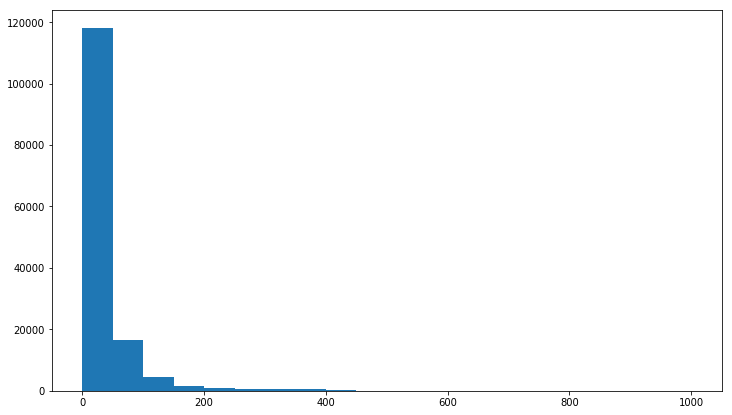

In [57]:
plt.figure(figsize=(12,7))
plt.hist(seq_len_train,bins=(0,50,100,150,200,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000))
plt.show()

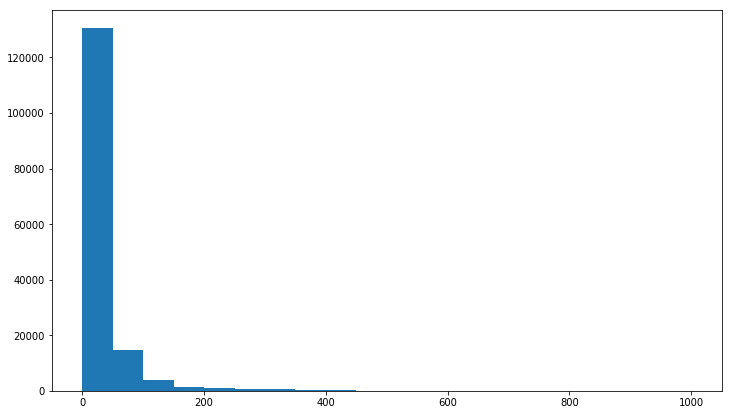

In [58]:
plt.figure(figsize=(12,7))
plt.hist(seq_len_test,bins=(0,50,100,150,200,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000))
plt.show()

In [59]:
from keras.preprocessing.sequence import pad_sequences

MAX_SEQ_LENGHT = 400
N_FEATURES = len(vectorizer.get_feature_names())

X_train_sequences = pad_sequences(X_train_sequences, maxlen=MAX_SEQ_LENGHT, value=N_FEATURES,padding='post',truncating='post')
X_val_sequences = pad_sequences(X_val_sequences, maxlen=MAX_SEQ_LENGHT, value=N_FEATURES,padding='post',truncating='post')
X_test_sequences = pad_sequences(X_test_sequences, maxlen=MAX_SEQ_LENGHT, value=N_FEATURES,padding='post',truncating='post') 

In [60]:
GLOVE_DIR = "/mnt/qlikviewdev_nfs/MIAProjects/DRG_Validation/project_v5/data/external"
EMBEDDING_DIM=50
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.50d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

embedding_matrix = np.random.random((len(word2idx) + 1, EMBEDDING_DIM))
for word, i in word2idx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [69]:
# https://keras.io/getting-started/functional-api-guide/
# https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html (for use of pretrained embeddings)
num_features = len(vectorizer.get_feature_names())
input_dim = num_features + 1

def build_nn_wembd(n1):
    '''
    n1
    '''

    # Headline input: meant to receive sequences of 100 integers, between 1 and 10000.
    # Note that we can name any layer by passing it a "name" argument.

    main_input = Input(shape=(MAX_SEQ_LENGHT,), dtype='int32', name='main_input')
    embedding_layer = Embedding(len(vectorizer.get_feature_names()) + 1,
                                EMBEDDING_DIM,# Embedding size,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQ_LENGHT,
                                trainable=True)
    embedded_sequences = embedding_layer(main_input)
    
    x = Conv1D(32, 8, activation='relu',padding='same')(embedded_sequences)
    x = MaxPooling1D(8)(x)

    x = Conv1D(32, 4, activation='softmax',padding='same')(x)
    x = AveragePooling1D(4)(x)

    #x = Conv1D(64, 4, activation='softmax',padding='same')(x)
    #x = MaxPooling1D(3)(x)

    #x = Conv1D(64, 4, activation='relu',padding='same')(x)
    #x = MaxPooling1D(8)(x)

    #x_out = Flatten()(x)

   # A LSTM will transform the vector sequence into a single vector,
   # containing information about the entire sequence
    lstm_out = Bidirectional(LSTM(64,dropout=0.2))(x)

   #auxiliary_output = Dense(146, activation='softmax', name='aux_output')(lstm_out)
    #auxiliary_output = Dense(6, activation='softmax', name='aux_output')(x_out)
    #auxiliary_input = Input(shape=(2954,), name='aux_input')
    x = lstm_out #concatenate([x_out, auxiliary_input])

    # We stack a deep densely-connected network on top

    x = Dense(n1, activation='relu',kernel_regularizer=regularizers.l2(0.00001),
              activity_regularizer=regularizers.l1(0.000001))(x)
    x = Dropout(0.4)(x)
    x = BatchNormalization()(x)

    #x = Dense(n2, activation='relu')(x)
    #x = Dropout(0.4)(x)
    #x = BatchNormalization()(x)
    #x = Dense(n3, activation='relu')(x)
    #x = Dropout(0.5)(x)
    #x = BatchNormalization()(x)
    # And finally we add the main logistic regression layer

    main_output = Dense(6, activation='sigmoid', name='main_output')(x)
    model = Model(inputs=main_input, outputs=main_output)
    #adadelta = Adadelta(lr=0.95)
    adam = Adam(lr=0.0005, beta_1=0.95, beta_2=0.999, epsilon=10**-8, decay=0.0001, amsgrad=False)
    model.compile(optimizer=adam, loss='binary_crossentropy',metrics=['accuracy'])

    print(model.summary())
    return model

In [70]:
cnn_model = build_nn_wembd(256)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 400)               0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 400, 50)           2632100   
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 400, 32)           12832     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 50, 32)            0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 50, 32)            4128      
_________________________________________________________________
average_pooling1d_6 (Average (None, 12, 32)            0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 128)               49664     
__________

In [71]:
cnn_model.fit(X_train_sequences, y_train,
        epochs=3, batch_size=64,validation_data=(X_val_sequences,y_val))

Train on 143613 samples, validate on 15958 samples
Epoch 1/3
143613/143613 [==============================] - 96s 666us/step - loss: 0.1023 - acc: 0.9699 - val_loss: 0.0553 - val_acc: 0.9806
Epoch 2/3
143613/143613 [==============================] - 92s 642us/step - loss: 0.0556 - acc: 0.9805 - val_loss: 0.0534 - val_acc: 0.9808
Epoch 3/3
143613/143613 [==============================] - 92s 640us/step - loss: 0.0494 - acc: 0.9823 - val_loss: 0.0498 - val_acc: 0.9816


In [72]:
pred = cnn_model.predict(X_test_sequences)

In [73]:
df_pred = pd.DataFrame(pred,columns=['toxic','severe_toxic','obscene','threat','insult','identity_hate'],index=df_test['id'])

In [74]:
df_pred.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,
00001cee341fdb12,0.981824,0.111260,0.851449,0.041405,0.727641,0.115655
0000247867823ef7,0.000484,0.000038,0.000110,0.000086,0.000165,0.000097
00013b17ad220c46,0.003659,0.000135,0.000619,0.000255,0.000968,0.000356
00017563c3f7919a,0.000636,0.000044,0.000138,0.000095,0.000201,0.000111
00017695ad8997eb,0.002811,0.000115,0.000494,0.000222,0.000764,0.000300


In [75]:
df_pred.to_csv('submission.csv')